# Main XGBOOST Pipeline

This is going to be a complicated problem, predicting high-frequency use is of huge importance to any hospital and emergency and there are many, many variables that can influence whether a patient returns to the hospital. 

With the consultaiton of a physician, high-frequency user was defined as anyone who visited the emergency department within 30 days of their last visit. Regardless of whether they showed up with the same symptoms or different ones. 

As such, this notebook is my attempt to create an XGBoost based learning model to predict readmission rate given a set of features. I explored around with both manual grid search and randomizedSearch with k-fold cross validation to optimize my models. Because of the large variability in this problem at it's core, my models, although high(ish) in accuracy, had poorer results in precision, recall, and f-1 scores. This is not surprising as other related papers that aim to identify patient re-admission also report similar precision (0.331), AUROC(0.739), and F1-scores(0.372), see: [text](https://www.nature.com/articles/s41598-020-58053-z#Tab1). 

## Data import and prep 

In [26]:
# xgboost with proper data preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import os

In [34]:
df = pd.read_csv('./preprocess_output/mimic_v6_labelled.csv')

print(df.shape)

(26176, 28)


So we have 26 thousand cases of data to use in this demo.  27 features and one response variable called 'Label' (we'll see that in a couple of steps). While this isn't the entirety of MIMIC-III dataset (not even close) I chose this numbber for this demo because it was small enough to run and at least show my thinking with. 

Additionally, data was selected and prepped using PostGreSQL, if I have time I'll put the specifics of data selection and pruning into this repo as well. 

There were some odd values in our feature set, take for example body temperature. Sometimes this value would be recorded as 4,5, or 6 instead of the actual temperature in degrees, and this shows up quite frequently in the dataset such that the average (mean) temperature in our data is 17.9C. So clearly temperature is coded differently than the raw thermostat value and other values like 4,5,6 are adding more complications to the variable. To get around this, I made a function that replaces any values of 4,5,6 with the last temperature value above 30C.

In [35]:
# Identify and replace erroneous temp values
# Sort the DataFrame by subject_id and any other relevant column (e.g., timestamp)
df.sort_values(by=['subject_id', 'admittime'], inplace=True)

# Create a function to replace the values of 6 with the last value above 30
def replace_values(group):
    last_above_30 = None
    new_temp = []

    for temp in group['temp']:
        if temp > 30:
            last_above_30 = temp
        elif last_above_30 is None:
            last_above_30 = 36.66667  # Default value if no values above 30
        new_temp.append(last_above_30 if temp in (4, 5, 6) else temp)

    group['temp'] = new_temp
    return group


# Apply the function to each group of unique participants
df = df.groupby('subject_id').apply(replace_values, include_groups=False)

# Reset the index of the DataFrame
df.reset_index(drop=True, inplace=True)

Clean up our dataset. First lets combine a couple of features into one, such as medication count. And because of the potential high cardinality in some of these features, we'll bin them into 1,2,3,4,>4 ordinal features. 

In [37]:
# clean df, remove unrequired features and setup categorical and numerical df
df['Medication_count'] = df['unique_cv_items_count'] + df['unique_mv_items_count']


bin_edges = [0, 1, 2, 3, 4, float('inf')]
bin_labels = ['1', '2', '3', '4', '>4']

# Apply binning to the 'num_unique_icd9_codes' column
df['num_unique_icd9_codes_bin'] = pd.cut(df['num_unique_icd9_codes'], bins=bin_edges, labels=bin_labels)

# Apply binning to the 'Medication_count' column
df['Medication_count_bin'] = pd.cut(df['Medication_count'], bins=bin_edges, labels=bin_labels)

df = df.drop(columns=['Unnamed: 0.1','Unnamed: 0','admittime',
                      'deathtime','marital_status',
                      'hadm_id', 'icd9_code_2','icd9_code_3',
                      'dischtime','admission_type',
                      'unique_cv_items_count','unique_mv_items_count',
                      'num_unique_icd9_codes','Medication_count','diagnosis'])

df= df.dropna() # also drop rows with NaN values 

Clean up age values. Age is something in the orignial dataset that is purposefully coded as values above 300 to anonymize the dataset but we can work around that.

In [38]:
# replace Age > 300
def replace_above_300(value):
    if value > 300:
        return value - 210
    return value

# Apply the function to the 'age' column
df['age'] = df['age'].apply(replace_above_300)

In [39]:
df.describe() # describe the numerical features 

,age,los,icd9_code_1,hr,nbp,spo2,rr,temp,Label
count,20883.000000,20883.000000,20883.000000,20883.000000,20883.000000,20883.000000,20883.000000,20883.000000,20883.000000
mean,63.304587,10.967243,4879.559690,88.512580,87.774858,97.259015,18.516545,33.622603,0.121391
std,17.304137,10.737337,3103.902339,20.586571,832.051419,4.633746,6.203092,10.019697,0.326588
min,18.022083,-0.116667,11.000000,0.000000,0.000000,0.000000,0.000000,0.777778,0.000000
25%,51.942804,4.739583,3601.000000,75.000000,69.000000,96.000000,14.000000,36.444401,0.000000
50%,64.843536,7.865972,3951.000000,87.000000,80.000000,98.000000,18.000000,36.666670,0.000000
75%,77.225612,13.505556,8102.000000,100.000000,92.333298,100.000000,22.000000,36.666670,0.000000
max,100.280859,202.762500,9978.000000,941.000000,120130.030000,100.000000,160.000000,40.833302,1.000000


In [40]:
df.keys()

Index(['age', 'gender', 'los', 'discharge_location', 'insurance', 'ethnicity',
       'icd9_code_1', 'hr', 'nbp', 'spo2', 'rr', 'temp', 'Label',
       'num_unique_icd9_codes_bin', 'Medication_count_bin'],
      dtype='object')

This shows our final list of features: Age, Gender, Length of Stay (LoS), Discharge Location, Insurance, Ethnicity, ICD9_Code_1 (1st diagnostic code given), Heart Rate (HR), NBP (Blood Pressure), SPO2 (Blood oxygenation %), Respiratory Rate (RR), Temperature (Temp), Num_unique_icd9_codes_bin (How many different diagnosis codes were given), Medication_count (how many medications taken), and finally the 'Label' category which is 0 for non-high frequency user and 1 for a high frequency user.

### Categorical Data Handling 

Of course, our dataset isn't just numerical, there are categorical data that we should handle proplerly. Here I've used SciKitLearn's Label Encoder to encode the following categorical features into integer values which I'll specify as categorical later on for XGBoost. 

I'm also thinking of doing One Hot Encoding for this but some feature have really high cardinality, which'll just really stretch my feature space and increase my dataset size, so I kept it as integer values for now. 

In [41]:
categ_columns = ['gender','discharge_location','insurance','ethnicity',
                      'icd9_code_1','num_unique_icd9_codes_bin','Medication_count_bin']

from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for column in categ_columns:
  label_encoder = LabelEncoder()
  df[column] = label_encoder.fit_transform(df[column])
  label_encoders[column] = label_encoder


Split into X and Y 

In [42]:
# split into X and y
y_df = df['Label']
y_df.columns = ['Label']

Perform numerical feature scaling, and outlier rejection using IQR rule (Outlier = 1.5 * IQR)

In [43]:
# Split X numerical and Categorical
x_df = df.copy()

#x_df_cat = x_df[['gender','discharge_location','insurance','ethnicity',
               # 'icd9_code_1','num_unique_icd9_codes_bin','Medication_count_bin']].copy()

x_df_cat = pd.get_dummies(df[['discharge_location','insurance','ethnicity','icd9_code_1','gender', 'Medication_count_bin', 'num_unique_icd9_codes_bin']])

x_df_num = x_df.drop(['gender','discharge_location','insurance','ethnicity',
                      'icd9_code_1','Label','num_unique_icd9_codes_bin','Medication_count_bin'], axis = 1).astype('float64')
x_df_num

,age,los,hr,nbp,spo2,rr,temp
0,76.526788,10.784722,95.0,36.666698,98.0,16.0,36.055599
1,47.845044,7.759028,111.0,80.666702,98.0,18.0,37.444401
2,50.148292,25.529167,90.0,64.000000,96.0,19.0,37.222198
3,39.866116,6.855556,80.0,71.333298,98.0,19.0,37.277802
5,50.841554,2.206250,95.0,113.667000,100.0,27.0,37.666698
...,...,...,...,...,...,...,...
26171,65.262831,6.814583,71.0,66.000000,95.0,18.0,36.666670
26172,65.377831,6.128472,94.0,71.000000,99.0,21.0,36.666670
26173,78.576622,3.079861,69.0,82.000000,98.0,21.0,36.666670
26174,53.808478,16.595833,118.0,102.000000,84.0,33.0,36.666670


In [44]:
# numerical is under x_df_num
X_numerical = x_df_num

In [45]:
print(len(x_df), len(y_df), len(x_df_num))

20883 20883 20883


In [46]:
list_numerical = X_numerical.columns
list_numerical

Index(['age', 'los', 'hr', 'nbp', 'spo2', 'rr', 'temp'], dtype='object')

In [47]:
for key in x_df_cat.keys():
    print('CATEGORICAL KEYS', key)

for key in x_df_num.keys():
    print('NUMERIC KEYS',key)

CATEGORICAL KEYS discharge_location
CATEGORICAL KEYS insurance
CATEGORICAL KEYS ethnicity
CATEGORICAL KEYS icd9_code_1
CATEGORICAL KEYS gender
CATEGORICAL KEYS Medication_count_bin
CATEGORICAL KEYS num_unique_icd9_codes_bin
NUMERIC KEYS age
NUMERIC KEYS los
NUMERIC KEYS hr
NUMERIC KEYS nbp
NUMERIC KEYS spo2
NUMERIC KEYS rr
NUMERIC KEYS temp


In [48]:
# Scale numerical features
scaled_x_df_num = pd.DataFrame(StandardScaler().fit_transform(x_df_num), columns = x_df_num.keys())

With FeatureScaling and StandardScaler(), the mean of each numerical variable across the dataset is standardized to having a 0 mean and a stdev of 1, which we can see below. (Don't worry about the Xe-18, these values are float point values which are realistically 0)

In [49]:
scaled_x_df_num.describe()

,age,los,hr,nbp,spo2,rr,temp
count,2.088300e+04,2.088300e+04,2.088300e+04,2.088300e+04,2.088300e+04,2.088300e+04,2.088300e+04
mean,-5.335110e-16,-1.224898e-16,-1.742077e-16,-1.360997e-18,2.653945e-17,-2.041496e-16,6.532788e-16
std,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00
min,-2.616923e+00,-1.032302e+00,-4.299633e+00,-1.054946e-01,-2.098979e+01,-2.985122e+00,-3.278104e+00
25%,-6.566092e-01,-5.800142e-01,-6.563941e-01,-2.256508e-02,-2.717121e-01,-7.281292e-01,2.816318e-01
50%,8.893741e-02,-2.888374e-01,-7.347585e-02,-9.344428e-03,1.599145e-01,-8.327410e-02,3.038155e-01
75%,8.045104e-01,2.364062e-01,5.580189e-01,5.478686e-03,5.915411e-01,5.615810e-01,3.038155e-01
max,2.136897e+00,1.786289e+01,4.141087e+01,1.442761e+02,5.915411e-01,2.280908e+01,7.196695e-01


Perform Outlier Rejection and use that to drop outlier indices from BOTH numerical and categorical features

In [51]:
# Find outliers based on 1.5*(Q3-Q1) outlier step
outliers  = []
# For each feature find the data points with extreme high or low values
for feature in scaled_x_df_num.keys():
    # Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(scaled_x_df_num[feature],25)
    # Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(scaled_x_df_num[feature],75)
    # Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = 1.5*(Q3-Q1)
    outliers_per_feature = scaled_x_df_num[~((scaled_x_df_num[feature] >= Q1 - step) & (scaled_x_df_num[feature] <= Q3 + step))]
    outliers = outliers + list(outliers_per_feature.index)
outliers.sort()
outliers = list(set(outliers))

# Remove outliers
clean_scaled_x_df_num = scaled_x_df_num.drop(scaled_x_df_num.index[outliers]).reset_index(drop = True)
clean_x_df_cat = x_df_cat.drop(x_df_cat.index[outliers]).reset_index(drop = True)
print('{} outliers removed'.format(len(outliers)))

8816 outliers removed


In [ ]:
# Convert categorical features to "One Hot Encoding" vectors and drop outliers
# clean_x_df_cat = x_df_cat.drop(x_df_cat.index[outliers]).reset_index(drop = True)
# clean_x_df_cat_ohe = pd.get_dummies(clean_x_df_cat, drop_first=True)
# dummies = pd.get_dummies(clean_x_df_cat)

Recombine Categorical and Numerical features into final dataset 

In [53]:
# Recombine scaled numerical and encoded categorical features by concatination
x_df = pd.concat([clean_scaled_x_df_num, clean_x_df_cat], axis = 1)

In [54]:
# Drop outliers from label Dataframe as well
y_df = y_df.drop(y_df.index[outliers]).reset_index(drop = True)

In [55]:
print(len(y_df), len(x_df))

12067 12067


In [56]:
y_df.columns = ['Label']

Get label proportions and positive label proportion (this'll determine class weights during learning)

In [57]:
print(y_df.value_counts())
print('\nPositive label proportion: ')
print(y_df.value_counts()/y_df.shape[0])

Label
0    10658
1     1409
Name: count, dtype: int64

Positive label proportion: 
Label
0    0.883235
1    0.116765
Name: count, dtype: float64


In [ ]:
# write final files to local dir
x_df.to_csv('/content/x_df_new.csv')
y_df.to_csv('/content/y_df_new.csv')

In [ ]:
# XGBOOST TIME

In [ ]:
#import all relevant libraries
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, roc_curve, auc
# from scipy import interp


Here I've imported essentially the same dataset that we made above but with the added feature of "diagnosis" as another categorical variable. This was done after more debate and discussion of missing the main "diagnostic" criteria as knew of what the patients were presenting with (ICD9 code) but we didn't have info on their diagnostic criterion. 

In [58]:
# Read preprocessed dataframes produced in notebook 2_preprocessing.ipynb
x_df = pd.read_csv('./preprocess_output/xy_with_diagnosis/x_df.csv')
y_df = pd.read_csv('./preprocess_output/xy_with_diagnosis/y_df.csv')

In [59]:
x_df = x_df.drop(columns = ['Unnamed: 0'])
print(x_df.keys())
print(x_df.dtypes)

Index(['age', 'los', 'hr', 'nbp', 'spo2', 'rr', 'temp', 'discharge_location',
       'insurance', 'ethnicity', 'icd9_code_1', 'gender',
       'Medication_count_bin', 'diagnosis', 'num_unique_icd9_codes_bin'],
      dtype='object')
age                          float64
los                          float64
hr                           float64
nbp                          float64
spo2                         float64
rr                           float64
temp                         float64
discharge_location             int64
insurance                      int64
ethnicity                      int64
icd9_code_1                    int64
gender                         int64
Medication_count_bin           int64
diagnosis                      int64
num_unique_icd9_codes_bin      int64
dtype: object


Here is where we convert the int64 values into categorical data

In [60]:
# Set int64 features to categories 
for key in x_df.keys():
    if x_df[key].dtype == 'int64':
        x_df[key] = x_df[key].astype('category')
        print('Converted {} to category'.format(key))
    else:
        print('Not converted {}'.format(key))

Not converted age
Not converted los
Not converted hr
Not converted nbp
Not converted spo2
Not converted rr
Not converted temp
Converted discharge_location to category
Converted insurance to category
Converted ethnicity to category
Converted icd9_code_1 to category
Converted gender to category
Converted Medication_count_bin to category
Converted diagnosis to category
Converted num_unique_icd9_codes_bin to category


In [61]:
print(x_df.dtypes)

age                           float64
los                           float64
hr                            float64
nbp                           float64
spo2                          float64
rr                            float64
temp                          float64
discharge_location           category
insurance                    category
ethnicity                    category
icd9_code_1                  category
gender                       category
Medication_count_bin         category
diagnosis                    category
num_unique_icd9_codes_bin    category
dtype: object


Define Class weights

In [62]:
# Define the class weight scale (a hyperparameter) as the ration of negative labels to positive labels.
# This instructs the classifier to address the class imbalance.
class_weight = 1.*y_df.Label.value_counts()[0]/y_df.Label.value_counts()[1]
class_weight

7.564229950319375

In [63]:
param={
    'objective':'binary:logistic',
    'nthread':4,
    'scale_pos_weight':class_weight,
    'seed' : 1,
    'enable_categorical': True, # enable categorical features 
    'eval_metric':'auc',
    
}
xgb1 = XGBClassifier()
xgb1.set_params(**param)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, nthread=4, ...)

So, lets just try a basic, out of the box initial classifier and see how we do with a 5 fold cross validation

class weight scale : 7.564229950319375
class weight scale : 7.564229950319375
class weight scale : 7.564229950319375
class weight scale : 7.564229950319375
class weight scale : 7.564229950319375


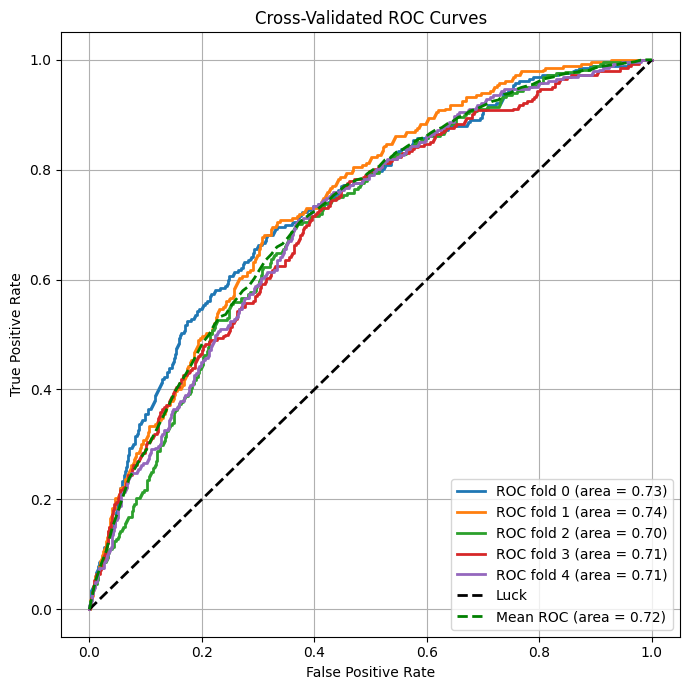

In [65]:
# Train initial classifier and analyze performace using K-fold cross-validation
K = 5
skf = StratifiedKFold(n_splits=K) # perserve proportion of classes in each fold so some folds are not entirely class 0 or 1 

fig = plt.figure(figsize=(7,7))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
lw = 2
i = 0
roc_aucs_xgb1 = []
# split into indices and fit classifier with class weight 
for train_indices, test_indices in skf.split(x_df, y_df['Label']): # skf is our stratified K-fold defined earlier 
    X_train, y_train = x_df.iloc[train_indices], y_df['Label'].iloc[train_indices] # split into train and test sets for each fold 
    X_valid, y_valid = x_df.iloc[test_indices], y_df['Label'].iloc[test_indices]
    print('class weight scale : {}'.format(class_weight)) # print class weight for each fold, they should be the same as overall dataset 
    
    xgb1.set_params(**{'scale_pos_weight' : class_weight})
    xgb1.fit(X_train,y_train)
    xgb1_pred_prob = xgb1.predict_proba(X_valid) # predict probabilities for each fold 
    
    fpr, tpr, thresholds = roc_curve(y_valid, xgb1_pred_prob[:, 1]) # compute False Positive Rate, True Positive Rate and Thresholds for ROC using class 1 probabilities 
    mean_tpr += np.interp(mean_fpr, fpr, tpr) # interpolate mean_fpr, fpr, and tpr 
    mean_tpr[0] = 0.0 # set first value of mean_tpr to 0
    roc_auc = auc(fpr, tpr) # calculate area under curve for each fold 
    roc_aucs_xgb1.append(roc_auc) # append to roc_aucs_xgb1 list 
    plt.plot(fpr, tpr, lw=lw, label='ROC fold %d (area = %0.2f)' % (i, roc_auc)) # plot the ROC curve for current fold 

    i += 1 #increment fold number 

plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Luck')

mean_tpr /= K
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Cross-Validated ROC Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

fig.savefig('./outputs/initial_ROC.png')

Great, we see a bunch of curves with different ROC that is around 0.72 (not the worst) but lets look at the real important metrics such as precision, and recall

In [66]:
# xgb1_nonopt = classification_report(y_true = y_df.Label, y_pred = np.zeros(y_df.shape[0]))
from sklearn.model_selection import cross_val_predict

xgb1_nonopt = cross_val_predict(xgb1, x_df, y_df['Label'], cv=5, method='predict')
print(classification_report(y_df['Label'], xgb1_nonopt))

              precision    recall  f1-score   support

           0       0.90      0.95      0.92     10658
           1       0.32      0.19      0.24      1409

    accuracy                           0.86     12067
   macro avg       0.61      0.57      0.58     12067
weighted avg       0.83      0.86      0.84     12067



Expected, our precision (0.32), recall (0.19) and F1-Score (0.24) with an un-optimized model was likely going to be not very good. So let's now try optimizing our hyperparameters such as 'n_estimators', 'max_depth', 'regularization_alpha' etc. 

Manual Grid-Search Hyperparameter Tuning

In [67]:
optimize = True
X_train = x_df
y_train = y_df['Label']

# manual grid search for hyperparameter optimization


# Optimization for n_estimators 
param_test0 = {'n_estimators':range(50,250,10)}
print('performing hyperparamter optimization step 0')
gsearch0 = GridSearchCV(estimator = xgb1, param_grid = param_test0,
                        scoring='roc_auc', n_jobs=1, cv=5)
gsearch0.fit(X_train,y_train)
print(gsearch0.best_params_, gsearch0.best_score_)

# optimization for max_depth and minimum child weight 
param_test1 = {'max_depth':range(1,10),
               'min_child_weight':range(1,10)}
print('performing hyperparamter optimization step 1')
gsearch1 = GridSearchCV(estimator = gsearch0.best_estimator_,
    param_grid = param_test1, scoring='roc_auc', n_jobs=1, cv=5)
gsearch1.fit(X_train,y_train)
print(gsearch1.best_params_, gsearch1.best_score_)

max_d = gsearch1.best_params_['max_depth']
min_c = gsearch1.best_params_['min_child_weight']


# optimization for gamma 
param_test2 = {'gamma':[i/10. for i in range(0,5)]}

print('performing hyperparamter optimization step 2')
gsearch2 = GridSearchCV(estimator = gsearch1.best_estimator_,
    param_grid = param_test2, scoring='roc_auc', n_jobs=1, cv=5)
gsearch2.fit(X_train,y_train)
print(gsearch2.best_params_, gsearch2.best_score_)

# optimization for subsample and colsample_bytree 
param_test3 = {'subsample':[i/10.0 for i in range(1,10)],
    'colsample_bytree':[i/10.0 for i in range(1,10)]}

print('performing hyperparamter optimization step 3')
gsearch3 = GridSearchCV(estimator = gsearch2.best_estimator_,
    param_grid = param_test3, scoring='roc_auc', n_jobs=1, cv=5)
gsearch3.fit(X_train,y_train)
print(gsearch3.best_params_, gsearch3.best_score_)

# alpha regularization term on weights 
param_test4 = {'reg_alpha':[0, 1e-5, 1e-3, 0.1, 10]}

print('performing hyperparamter optimization step 4')
gsearch4 = GridSearchCV(estimator = gsearch3.best_estimator_,
    param_grid = param_test4, scoring='roc_auc', n_jobs=1, cv=5)
gsearch4.fit(X_train,y_train)
print(gsearch4.best_params_, gsearch4.best_score_)

alpha = gsearch4.best_params_['reg_alpha']
if alpha != 0:
    param_test4b = {'reg_alpha':[0.1*alpha, 0.25*alpha, 0.5*alpha, alpha, 2.5*alpha, 5*alpha, 10*alpha]}
    
    print('performing hyperparamter optimization step 4b')
    gsearch4b = GridSearchCV(estimator = gsearch4.best_estimator_,
        param_grid = param_test4b, scoring='roc_auc', n_jobs=1, cv=5)
    
    gsearch4b.fit(X_train,y_train)
    print(gsearch4b.best_params_, gsearch4.best_score_)
    print('\nParameter optimization finished!')
    xgb_opt = gsearch4b.best_estimator_
    
    xgb_opt.set_params(**{'enable_categorical' : True})
    
    xgb_opt
else:
    xgb_opt = gsearch4.best_estimator_
    xgb_opt

print(xgb_opt)

performing hyperparamter optimization step 0
{'n_estimators': 80} 0.7185798941989187
performing hyperparamter optimization step 1
{'max_depth': 2, 'min_child_weight': 7} 0.7578858334170431
performing hyperparamter optimization step 2
{'gamma': 0.0} 0.7578858334170431
performing hyperparamter optimization step 3
{'colsample_bytree': 0.8, 'subsample': 0.9} 0.7554182502478317
performing hyperparamter optimization step 4
{'reg_alpha': 0.1} 0.756581017188973
performing hyperparamter optimization step 4b
{'reg_alpha': 1.0} 0.756581017188973

Parameter optimization finished!
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=0.0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              lea

We have outputs for hyperparameter optimization and their values that we've calculated. And how we run the same pipeline again as previous but with this newly optimized model (xgb_opt) instead. 

class weight scale : 7.564229950319375
class weight scale : 7.564229950319375
class weight scale : 7.564229950319375
class weight scale : 7.564229950319375
class weight scale : 7.564229950319375


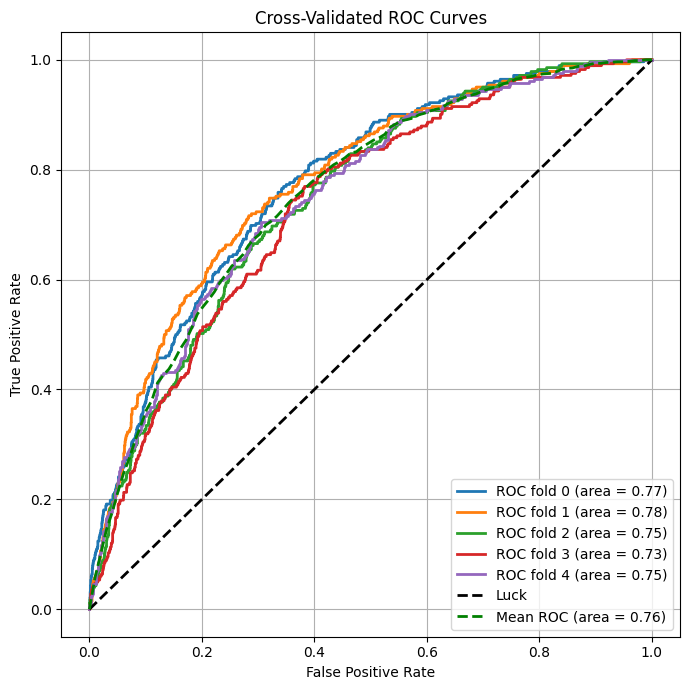

In [68]:
# K fold cross validation
K = 5

skf = StratifiedKFold(n_splits=K)


fig = plt.figure(figsize=(7,7))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
lw = 2
i = 0
roc_aucs_xgbopt = []
# split into train an test indices again and use optimized classifier 
for train_indices, test_indices in skf.split(x_df, y_df['Label']):
    X_train, y_train = x_df.iloc[train_indices], y_df['Label'].iloc[train_indices]
    X_valid, y_valid = x_df.iloc[test_indices], y_df['Label'].iloc[test_indices]
    print('class weight scale : {}'.format(class_weight))
    
    xgb_opt.set_params(**{'scale_pos_weight' : class_weight})
    xgb_opt.fit(X_train,y_train)
    xgb_opt_pred_prob = xgb_opt.predict_proba(X_valid)
    fpr, tpr, thresholds = roc_curve(y_valid, xgb_opt_pred_prob[:, 1])
    mean_tpr += np.interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    roc_aucs_xgbopt.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    i += 1

plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Luck')

mean_tpr /= K
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Cross-Validated ROC Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()

fig.savefig('./outputs/ROC.png')

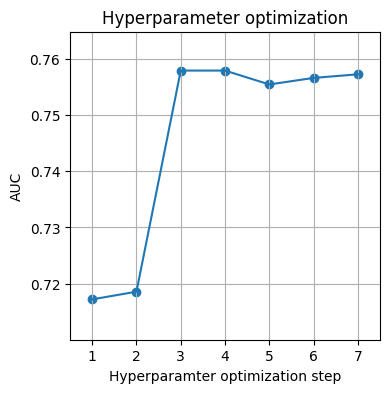

In [69]:
if optimize:

    aucs = [np.mean(roc_aucs_xgb1),
            gsearch0.best_score_,
            gsearch1.best_score_,
            gsearch2.best_score_,
            gsearch3.best_score_,
            gsearch4.best_score_,
            np.mean(roc_aucs_xgbopt)]

    fig = plt.figure(figsize=(4,4))
    plt.scatter(np.arange(1,len(aucs)+1), aucs)
    plt.plot(np.arange(1,len(aucs)+1), aucs)
    plt.xlim([0.5, len(aucs)+0.5])
    plt.ylim([0.99*aucs[0], 1.01*aucs[-1]])
    plt.xlabel('Hyperparamter optimization step')
    plt.ylabel('AUC')
    plt.title('Hyperparameter optimization')
    plt.grid()
    fig.savefig('./outputs/optimization.png')

Ok, from these two graphs above we do see improvements, certainly, in AUROC and the mean ROC goes from 0.72 -> 0.76, but what about our ever imporant recall, precision and F1 scores?

In [70]:
xgb_opt_test = cross_val_predict(xgb_opt, x_df, y_df['Label'], cv=5, method='predict')
print(classification_report(y_df['Label'], xgb_opt_test))

              precision    recall  f1-score   support

           0       0.94      0.74      0.83     10658
           1       0.24      0.64      0.35      1409

    accuracy                           0.72     12067
   macro avg       0.59      0.69      0.59     12067
weighted avg       0.86      0.72      0.77     12067



We've got a substantial improvement in recall in our minority class (0.19 -> 0.64) and a good jump in f1 score, from 0.24 to 0.35. However, our precision has taken a hit which needs to be investigated further. Overall this has dropped our accuracy overall compared to the non-optimized XGBoost model which could be evidence of model over-fitting. 

Next steps to do would be to optimize using a RandomizedSearch instead of a manual grid search. 

But before that let's just for the fun of it see what features are driving my results:

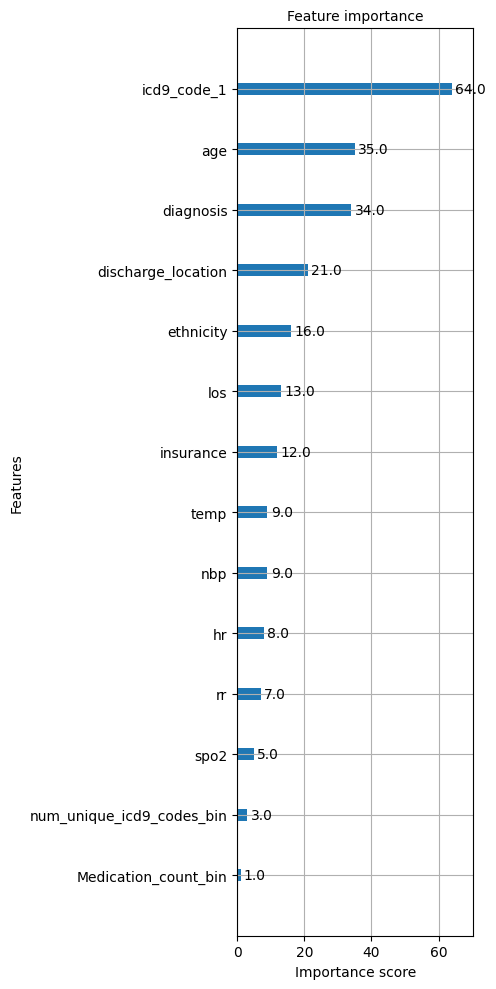

In [71]:
def my_plot_importance(booster, figsize, **kwargs):
    from matplotlib import pyplot as plt
    from xgboost import plot_importance
    fig, ax = plt.subplots(1,1,figsize=(figsize))
    plot_importance(booster=booster, ax=ax, **kwargs)
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label,] +
ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(10)
    plt.tight_layout()
    fig.savefig('./outputs/Feature_importance.png')

my_plot_importance(xgb_opt, (5,10))

This should make sense intituitively, what a patient presents to the ED with (ICD9 code), their age, their specific diagnosis, and finally WHERE they get discharged TO all play the biggest role in determining whether a specific user may be a high frequency user of the ED. 

Interestingly, their vital signs, like Blood Pressure, Heart Rate, Respiratory rate, and how many different types of issues they're presenting with don't play a large role in the model importance. 

New method: RandomizedSearchCV

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from scipy.stats import uniform, randint
import joblib

# Using RandomizedSearch CV instead of manual GridSearch for hyperparameter optimize 
X = x_df
y = y_df['Label']
class_weight = (y == 0).sum() / (y == 1).sum()

# Init XGBoost 
xgb_base = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    use_label_encoder=False,
    scale_pos_weight=class_weight,
    n_jobs=-1,
    verbosity=0,
    random_state=42
)

# init hyperparameters  
param_dist = {
    'n_estimators': randint(50, 250),
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 10),
    'gamma': uniform(0, 0.5),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'reg_alpha': uniform(0, 10),
    'learning_rate': uniform(0.01, 0.2),
    'enable_categorical': [True], # Used categorical features, should probably try to also do this with OHE(?) but that'll explode the feature space 
    'scale_pos_weight': [class_weight],
}

# Stratifying K-folds to use in randomized search 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Setup RandomizedSearchCV 
random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=50,
    scoring='roc_auc',
    cv=cv,
    verbose=2,
    random_state=42,
    return_train_score=True
)

# Split data into train and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y) 


# Fit the model on training data and find best hyperparameters 
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_

# Re-train the best fitting model on full training data
best_model.fit(X_train, y_train)

# === EVALUATE FULL DATA ===
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1] # get probabilites for class 1 

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("ROC AUC (Full Data):", roc_auc_score(y_test, y_proba))

# === ROC CURVES FROM CV ===
fig = plt.figure(figsize=(8, 8))
mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []

for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_valid, y_valid = X.iloc[test_idx], y.iloc[test_idx]
    
    best_model.fit(X_train, y_train)
    probas_ = best_model.predict_proba(X_valid)
    
    fpr, tpr, _ = roc_curve(y_valid, probas_[:, 1])
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    
    plt.plot(fpr, tpr, lw=1.5, alpha=0.5, label=f"Fold {i+1} (AUC = {roc_auc:.2f})")

# === MEAN ROC CURVE ===
mean_tpr = np.mean(tprs, axis=0)
std_tpr = np.std(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='b', lw=2.5,
         label=f"Mean ROC (AUC = {mean_auc:.2f})")

# === SHADED STD DEVIATION ===
plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr,
                 color='b', alpha=0.2, label='±1 std dev')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Cross-Validated ROC Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig('./outputs/cv_roc_curves.png')
plt.show()

# === SAVE MODEL ===
joblib.dump(best_model, './outputs/xgb_best_model.pkl')


In [ ]:
print("\nClassification Report: Stratified K-Fold with Randomized Search (not manual grid search)") 
print(classification_report(y_test, y_pred))

In [72]:
print("\n Classification report: Optimized manual grid-search")
xgb_opt_test = cross_val_predict(xgb_opt, x_df, y_df['Label'], cv=5, method='predict')
print(classification_report(y_df['Label'], xgb_opt_test))

# xgb1_nonopt = cross_val_predict(xgb1, x_df, y_df['Label'], cv=5, method='predict')
# print(classification_report(y_df['Label'], xgb1_nonopt))


 Classification report: Optimized manual grid-search
              precision    recall  f1-score   support

           0       0.94      0.74      0.83     10658
           1       0.24      0.64      0.35      1409

    accuracy                           0.72     12067
   macro avg       0.59      0.69      0.59     12067
weighted avg       0.86      0.72      0.77     12067



In [ ]:

print("\n Classification report: Untrained, initial Model")

y_pred_cv = cross_val_predict(xgb1, x_df, y_df['Label'], cv=5, method='predict')
print(classification_report(y_df['Label'], y_pred_cv))

In [ ]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(xgb1)
shap_values = explainer.shap_values(x_df)
shap.initjs()

shap.summary_plot(shap_values, x_df)
shap.initjs()

shap.summary_plot(shap_values, x_df, plot_type = "bar")